In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow
import random

# Set random seed for reproducibility
np.random.seed(0)
tensorflow.random.set_seed(0)
random.seed(0)


In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load and preprocess the data
df = pd.read_excel('/content/drive/MyDrive/seema/Copy of val.xlsx')

In [7]:
df.head()

,Tweet,class,Sub,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,كتبك هي من تسب الآخرين و تصفهم بأقذر الألقاب م...,1,R-HS,NaN,NaN,NaN
1,اخونجي متطرف يعشق الفتنه والخراب لغيره وعشان ك...,1,S-HS,NaN,NaN,NaN
2,احسنت هذا عباله كل واحد عايش في لندن خائن,0,NaN,NaN,NaN,NaN
3,الطيور على أشكالها تقع ، الطغاة يحتفلون بوتين ...,1,P-HS,NaN,NaN,NaN
4,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS,NaN,NaN,ملاحظة


In [8]:
df = df[['Tweet','class','Sub']]

### **Preprocessing**

In [9]:
X = df['Tweet'].astype(str)
y = df['class']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [10]:
# sub_y = df['Sub'].values
# sub_y_train, sub_y_val = sub_y[train_idx], sub_y[val_idx]

### **Tokenization and padding**

In [11]:
max_words = 10000  # Max number of words in tokenizer
max_len = 62  # Max sequence length
embed_dim = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

### **Word Embedding Matrix**

In [12]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz; gunzip cc.ar.300.vec.gz

--2024-05-11 17:22:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G   219MB/s    in 6.4s    

2024-05-11 17:22:48 (189 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [13]:
# Step 1: Load FastText Model
import gensim
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.ar.300.vec', binary=False)

In [14]:
# Step 2: Create Embedding Matrix from FastText
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # FastText vectors are 300-dimensional
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_vector = fasttext_model[word]
        embedding_matrix[i] = embedding_vector

### **Models**

In [15]:
# Define a list of deep learning models to experiment with
models = [

    ('GRU', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        GRU(64, kernel_initializer='glorot_uniform'),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])),
      ('RNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        SimpleRNN(64),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])),

    ('LSTM', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(64,  kernel_initializer='glorot_uniform'),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])),
    ('BiLSTM', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Bidirectional(LSTM(64,  kernel_initializer='glorot_uniform' )),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])),
    ('CNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Conv1D(128, 5, activation='relu',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))

]


### **Train 5 cross validation**

In [16]:
!export TF_DETERMINISTIC_OPS=1

In [ ]:
# Stratified cross-validation with 10 folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'history'])

output_dir = '/content/drive/MyDrive/seema'
# Training and evaluation loop for each model
for name, model in models:
    print(f'Training and evaluating {name} with {n_splits}-fold stratified cross-validation...')
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_pad, y), 1):
        X_train, X_val = X_pad[train_idx], X_pad[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

        # Define callbacks (checkpoint and early stopping)
        checkpoint = ModelCheckpoint(f'{output_dir}/checkpoints/{name}_fold{fold_idx}.h5', monitor='val_loss', save_best_only=True, verbose=0)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

        # Train the model with callbacks
        history = model.fit(X_train, y_train, epochs=150, batch_size=128,
                            validation_data=(X_val, y_val),
                            callbacks=[checkpoint, early_stopping],
                            verbose=0)

        # Load the best model for prediction
        best_model = load_model(f'{output_dir}/checkpoints/{name}_fold{fold_idx}.h5')

        # Evaluate the model on the validation set
        y_pred = (best_model.predict(X_val) > 0.5).astype(int)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        # Store the results for this fold
        fold_results.append([name, fold_idx, accuracy, precision, recall, f1, history.history])

    # Append fold results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(fold_results, columns=results_df.columns)],
                           ignore_index=True)


    # Calculate average metrics across all folds for this model
    avg_accuracy = np.mean(results_df[results_df['Model'] == name]['Accuracy'])
    avg_precision = np.mean(results_df[results_df['Model'] == name]['Precision'])
    avg_recall = np.mean(results_df[results_df['Model'] == name]['Recall'])
    avg_f1 = np.mean(results_df[results_df['Model'] == name]['F1 Score'])

    print(f'Average metrics for {name}:')
    print(f'Average Accuracy: {avg_accuracy:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print(f'Average F1 Score: {avg_f1:.4f}')
    print('')

# Save results to a CSV file
results_df.to_csv(f'{output_dir}/results/non_trainable_rnn_model_results.csv', index=False)

Training and evaluating GRU with 5-fold stratified cross-validation...
50/50 [==============================] - 3s 38ms/step
Average metrics for GRU:
Average Accuracy: 0.8218
Average Precision: 0.8560
Average Recall: 0.8219
Average F1 Score: 0.8385

Training and evaluating RNN with 5-fold stratified cross-validation...
50/50 [==============================] - 1s 14ms/step
Average metrics for RNN:
Average Accuracy: 0.7977
Average Precision: 0.8497
Average Recall: 0.7783
Average F1 Score: 0.8124

Training and evaluating LSTM with 5-fold stratified cross-validation...
50/50 [==============================] - 3s 43ms/step
Average metrics for LSTM:
Average Accuracy: 0.7997
Average Precision: 0.8268
Average Recall: 0.8147
Average F1 Score: 0.8207

Training and evaluating BiLSTM with 5-fold stratified cross-validation...
50/50 [==============================] - 5s 79ms/step
Average metrics for BiLSTM:
Average Accuracy: 0.7968
Average Precision: 0.8202
Average Recall: 0.8187
Average F1 Score: 

In [ ]:
import pandas as pd
results_df = pd.read_csv('/content/drive/MyDrive/seema/results/non_trainable_rnn_model_results.csv')

In [ ]:
results_df

,Model,Fold,Accuracy,Precision,Recall,F1 Score,history
0,GRU,1,0.790536,0.819635,0.804933,0.812217,"{'loss': [0.6918158531188965, 0.68838250637054..."
1,GRU,2,0.829653,0.865882,0.825112,0.845006,"{'loss': [0.40262457728385925, 0.3988198041915..."
2,GRU,3,0.832702,0.859770,0.839506,0.849517,"{'loss': [0.4001034200191498, 0.39825487136840..."
3,GRU,4,0.816288,0.849650,0.818182,0.833619,"{'loss': [0.39497262239456177, 0.3928336203098..."
4,GRU,5,0.839646,0.885127,0.821549,0.852154,"{'loss': [0.3977124094963074, 0.39420518279075..."
5,RNN,1,0.766562,0.815217,0.756726,0.784884,"{'loss': [0.6887926459312439, 0.67575973272323..."
6,RNN,2,0.813249,0.877215,0.776906,0.824019,"{'loss': [0.4678691029548645, 0.45983129739761..."
7,RNN,3,0.798611,0.842105,0.790123,0.815287,"{'loss': [0.4641987979412079, 0.45485478639602..."
8,RNN,4,0.802399,0.855911,0.780022,0.816207,"{'loss': [0.4578503370285034, 0.45033672451972..."
9,RNN,5,0.807449,0.858191,0.787879,0.821533,"{'loss': [0.45849400758743286, 0.4519563317298..."


In [ ]:
import ast

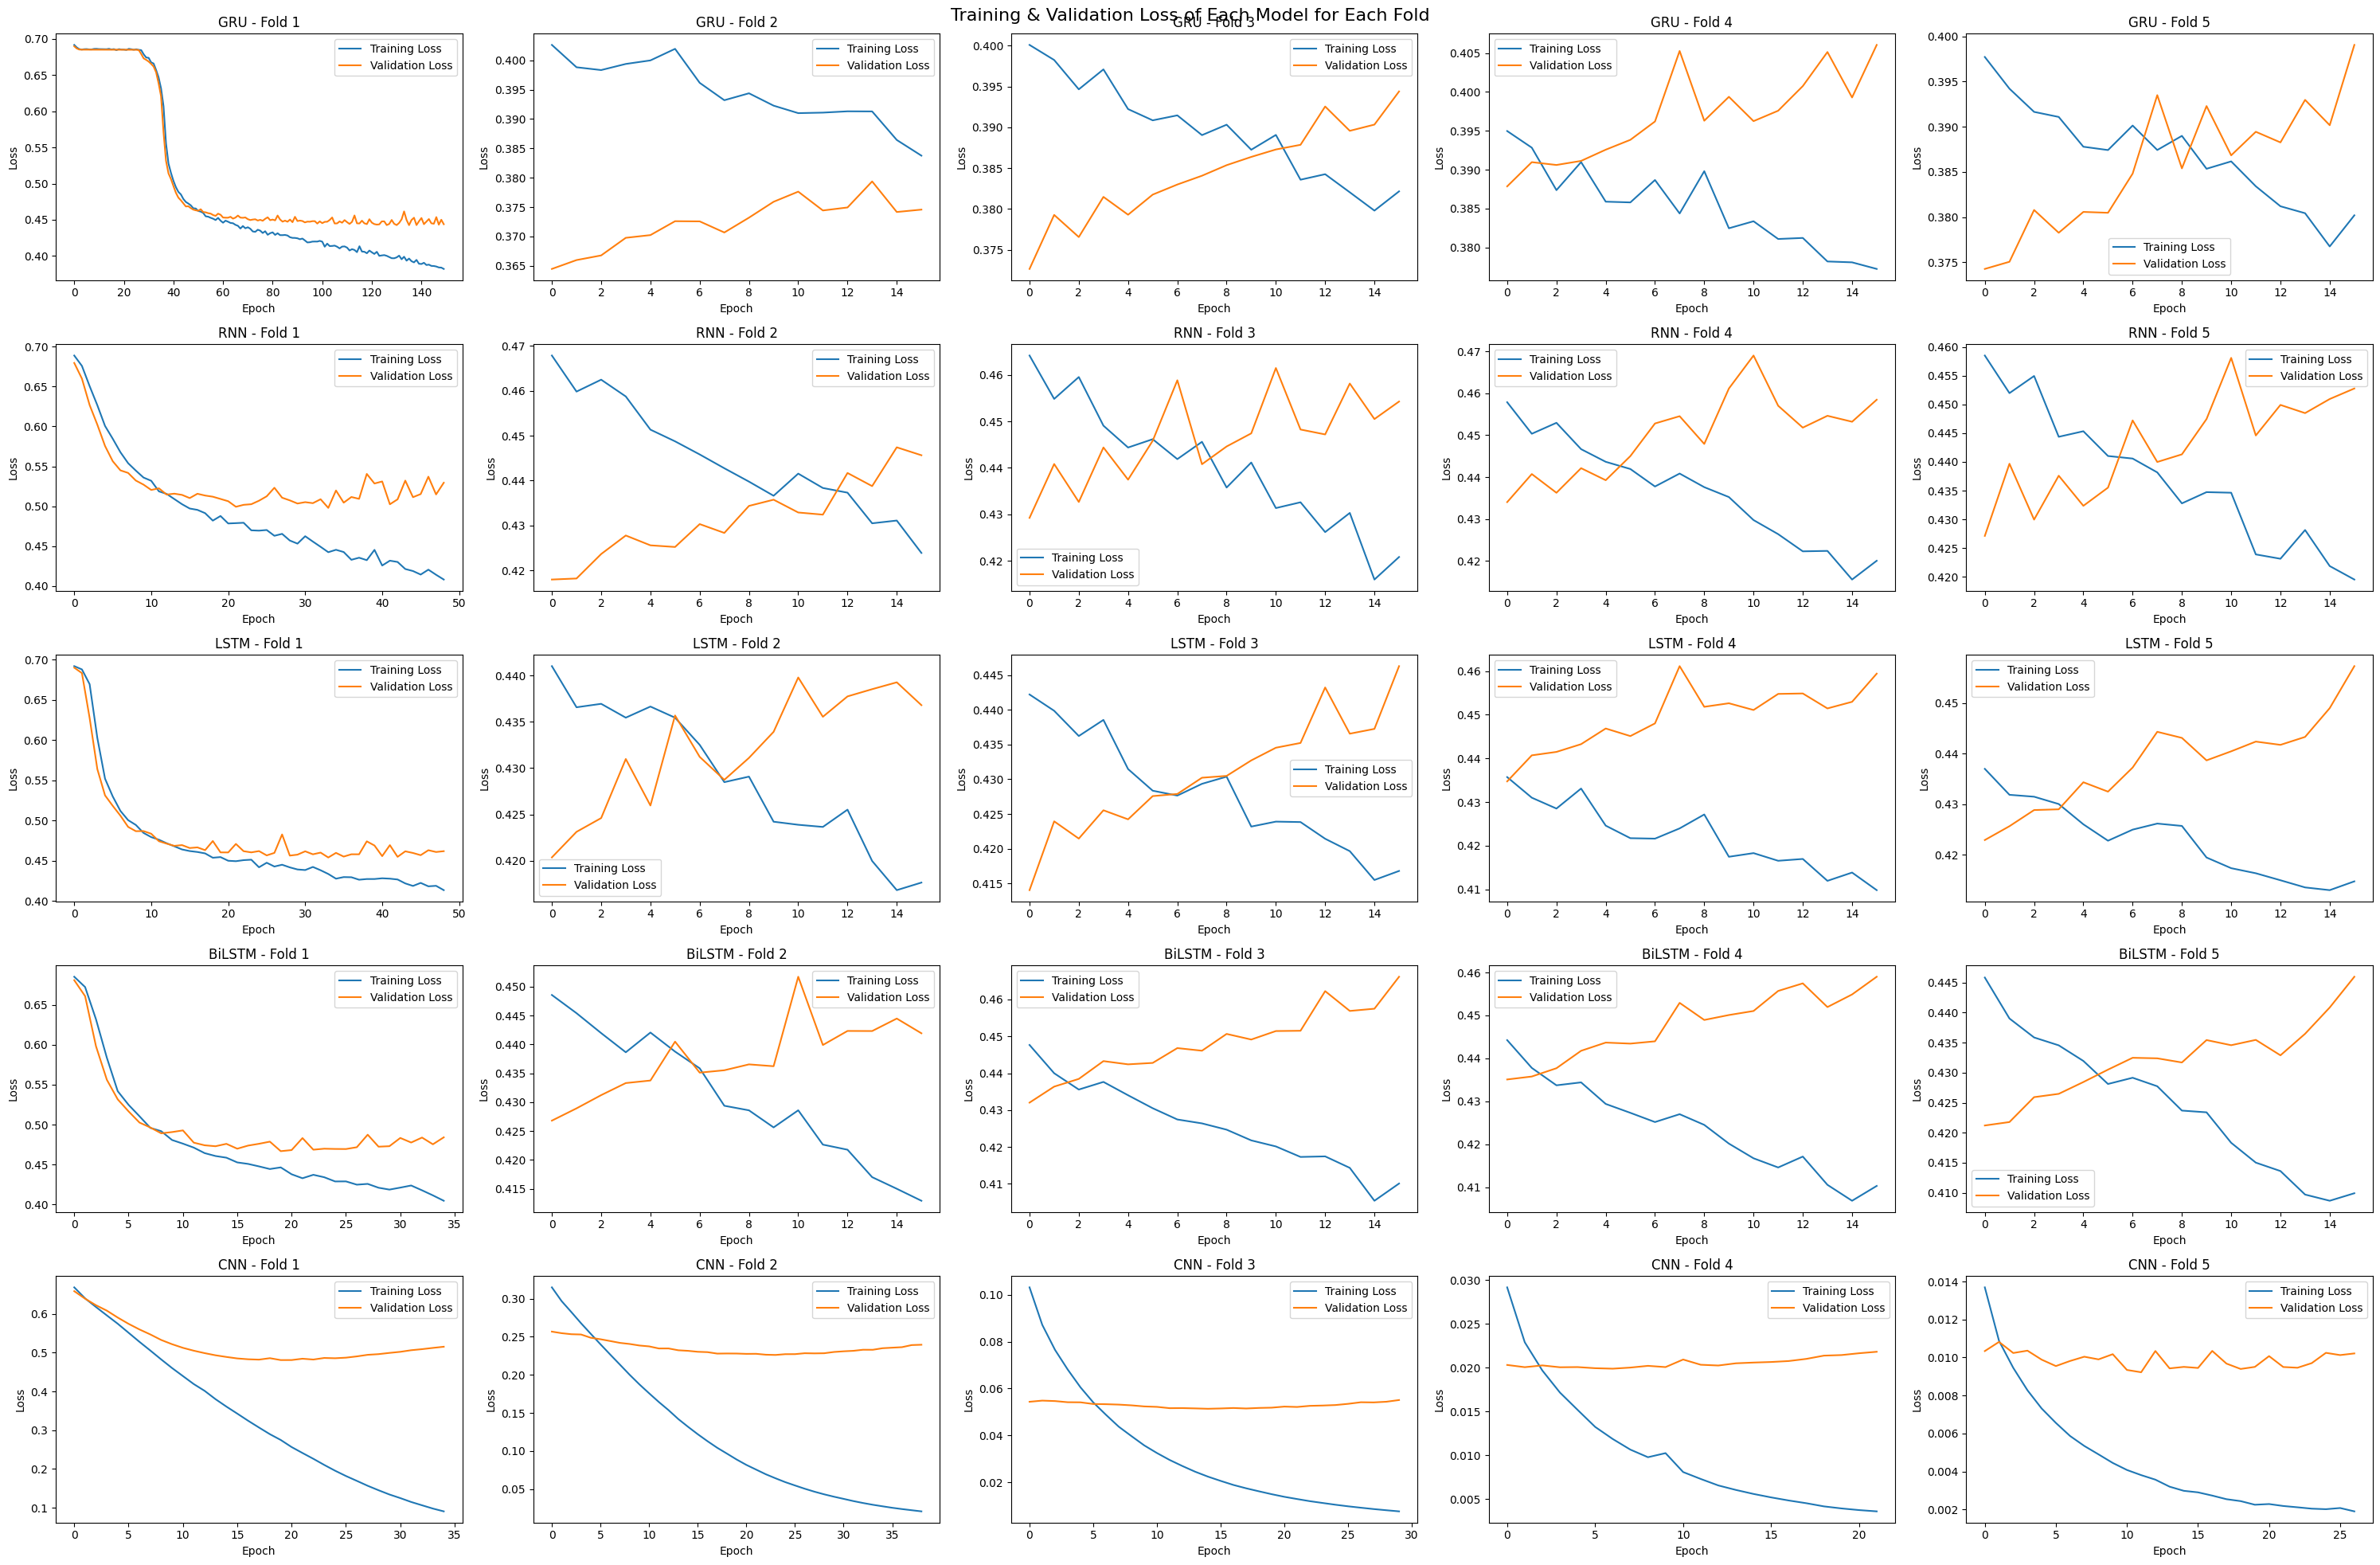

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of models and folds
num_models = len(results_df['Model'].unique())
num_folds = len(results_df['Fold'].unique())

# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(30, 4*num_models))
fig.suptitle('Training & Validation Loss of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[i, j].plot(history['loss'], label='Training Loss')
        axes[i, j].plot(history['val_loss'], label='Validation Loss')
        axes[i, j].set_title(f'{model} - Fold {fold}')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Loss')
        axes[i, j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(30, 4*num_models))
fig.suptitle('Training & Validation Accuracy of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[i, j].plot(history['accuracy'], label='Training Acc')
        axes[i, j].plot(history['val_accuracy'], label='Validation Acc')
        axes[i, j].set_title(f'{model} - Fold {fold}')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Accuracy')
        axes[i, j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
